In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')

## Evaluation Metrics for Classification

In this module we'll continue using the "Churn Prediction Project". We will be implementing model evaluation techniques (as we already have the data and model artifacts from previous modules, we will import them directly from Google Cloud Storage).

Now, let's answer a question: is 80% [accuracy](https://developers.google.com/machine-learning/glossary#accuracy) good enough? (for our use case). What is accuracy?

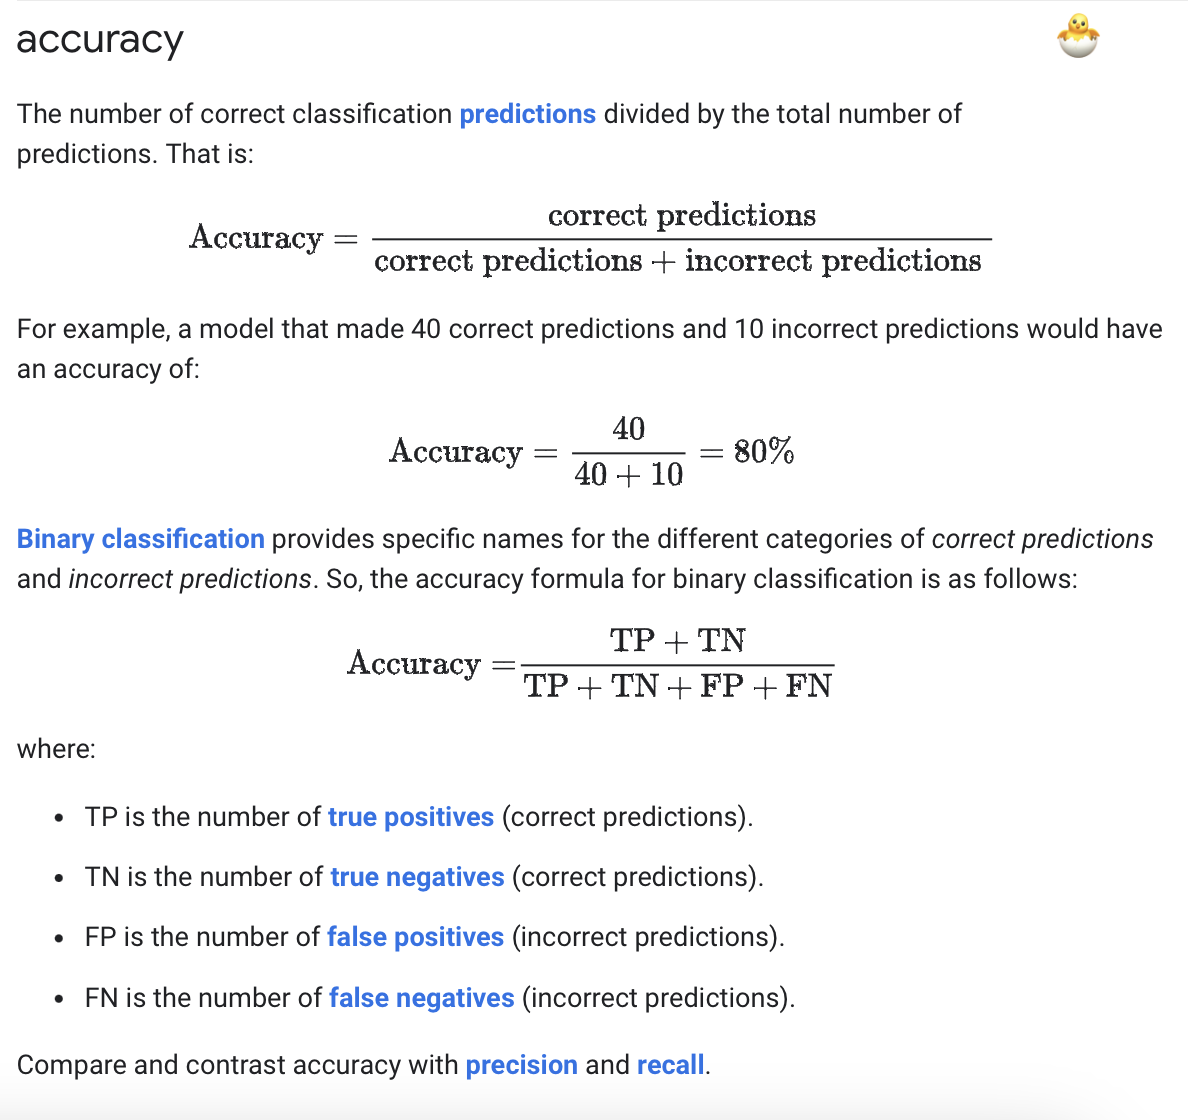

### 1. Calculating Accuracy

In [ ]:
import pandas as pd
import pickle
import numpy as np

from gcp_python_client_functions.clients import *

stg_obj = Storage(PROJECT_ID)
bucket = stg_obj.client.bucket(BUCKET_NAME)

blob = bucket.blob("02_churn_prediction/pipeline_root/532579765435/pipeline-log-reg-20231002003733/train-log-reg_6552710657228144640/out_model.pkl")
pickle_in = blob.download_as_string()
model = pickle.loads(pickle_in)

blob = bucket.blob("02_churn_prediction/pipeline_root/532579765435/pipeline-log-reg-20231002003733/preprocess-data-2_-1517739875019784192/out_X.pkl")
pickle_in = blob.download_as_string()
x_val = pickle.loads(pickle_in)

blob = bucket.blob("02_churn_prediction/pipeline_root/532579765435/pipeline-log-reg-20231002003733/preprocess-data-2_-1517739875019784192/out_y.pkl")
pickle_in = blob.download_as_string()
y_val = pickle.loads(pickle_in)

In [ ]:
y_val.head()

0    0
1    0
2    0
3    1
4    0
dtype: int64

In [ ]:
y_pred_val = model.predict_proba(x_val)[:,1]

In [ ]:
print(y_pred_val)

[0.00990341 0.16804322 0.1800816  ... 0.15241447 0.81156571 0.83843991]


Let's get the accuracy for different prediction theresholds.

In [ ]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0,1,21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred_val >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.501
0.10 0.598
0.15 0.664
0.20 0.720
0.25 0.749
0.30 0.762
0.35 0.768
0.40 0.785
0.45 0.798
0.50 0.804
0.55 0.804
0.60 0.796
0.65 0.792
0.70 0.771
0.75 0.745
0.80 0.737
0.85 0.727
0.90 0.726
0.95 0.726
1.00 0.726


[<matplotlib.lines.Line2D>]

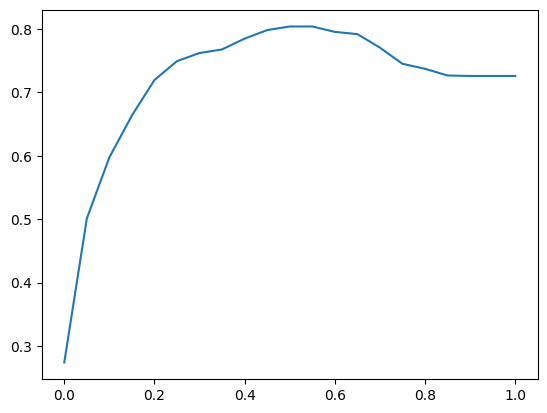

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, scores)

We can see how indeed .5 gives us the highest accuracy.

In [ ]:
from collections import Counter

Counter(y_pred_val >= .5)

Counter({False: 1107, True: 302})

In [ ]:
Counter(y_val == 1)

Counter({False: 1023, True: 386})

In [ ]:
1 - 386/(1023+386)

0.7260468417317246

So if we predicted every customer as no churning we would have an accuracy of 73%.

### 2. Confusion Matrix

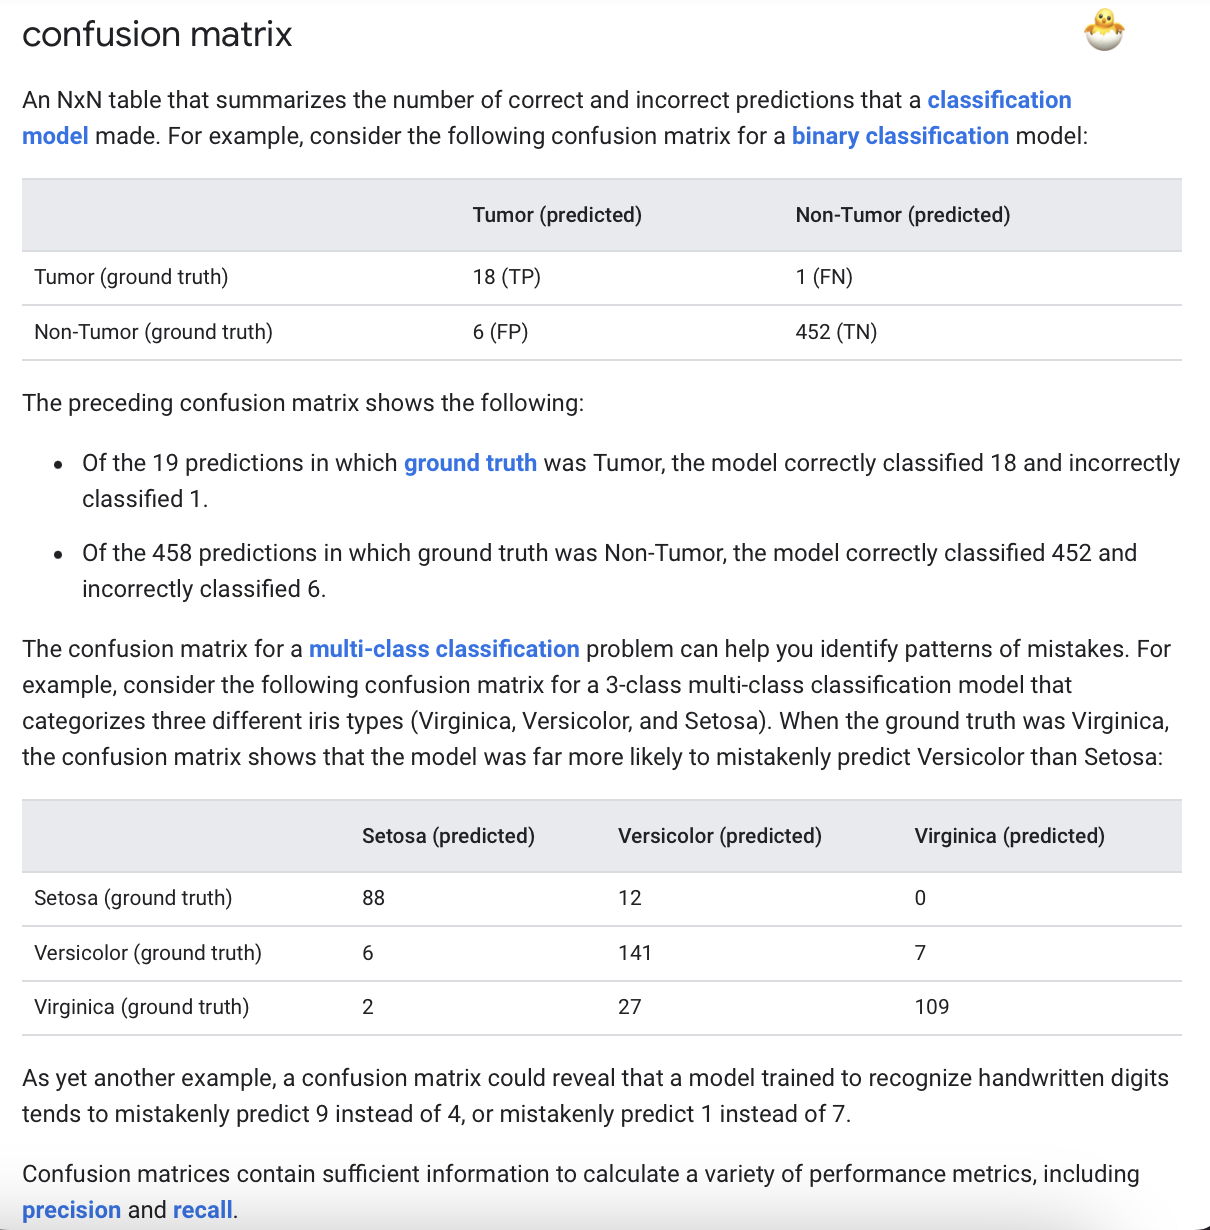

In [ ]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [ ]:
t = 0.5
predict_positive = (y_pred_val >= t)
predict_negative = (y_pred_val < t)

In [ ]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [ ]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[927,  96],
       [180, 206]])

In [ ]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.13, 0.15]])

### 3. Precision & Recall

**Precision**: Fraction of positive predictions that are actually correct.
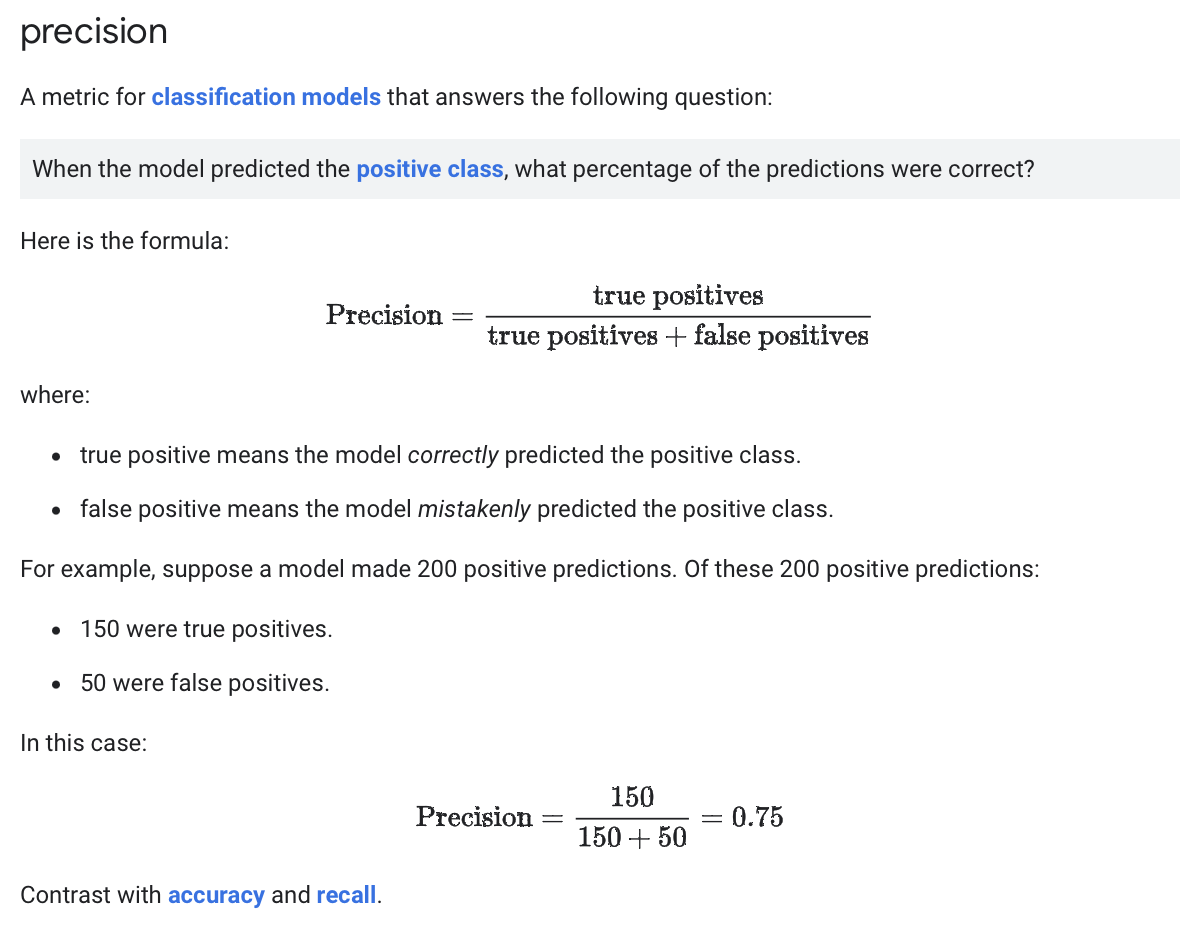

In our example:
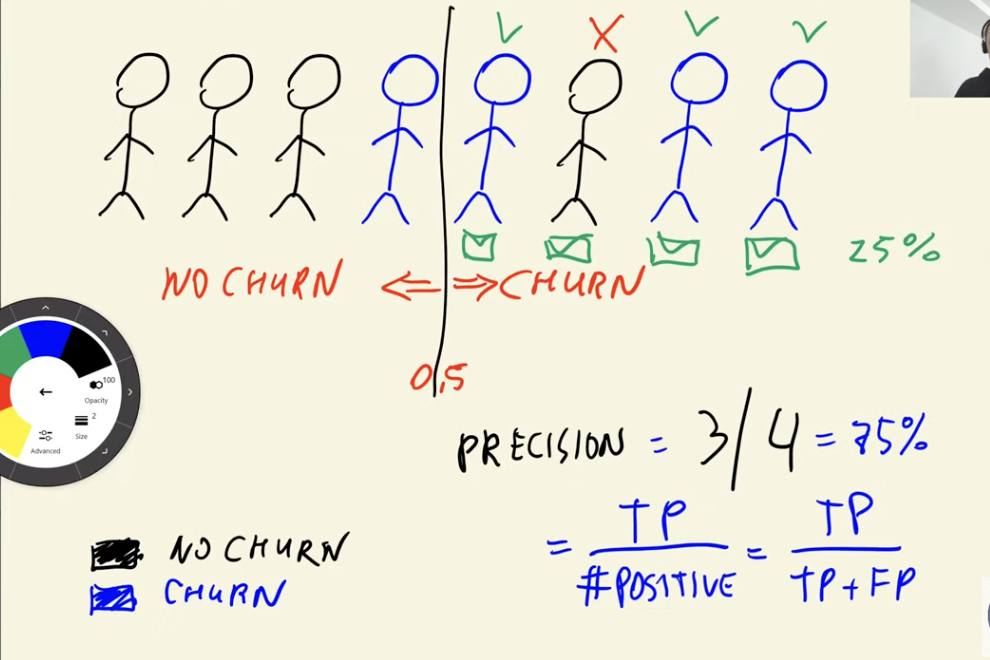

In [ ]:
p = tp / (tp + fp)
p

0.6821192052980133

This means 32% of customers we would send discounts to would leverage from them without being necessary.

**Recall:** fraction of correctly identified positive examples.

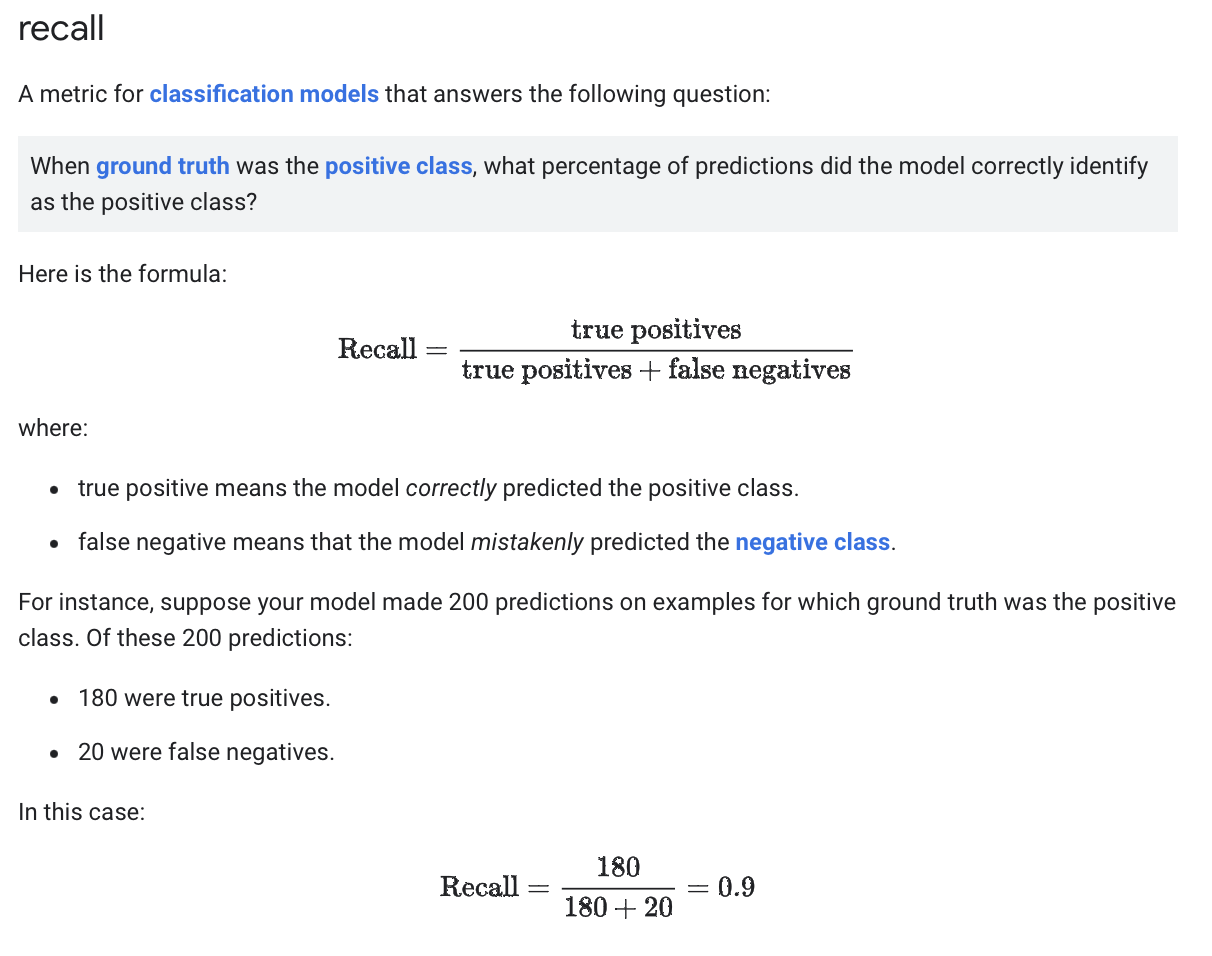

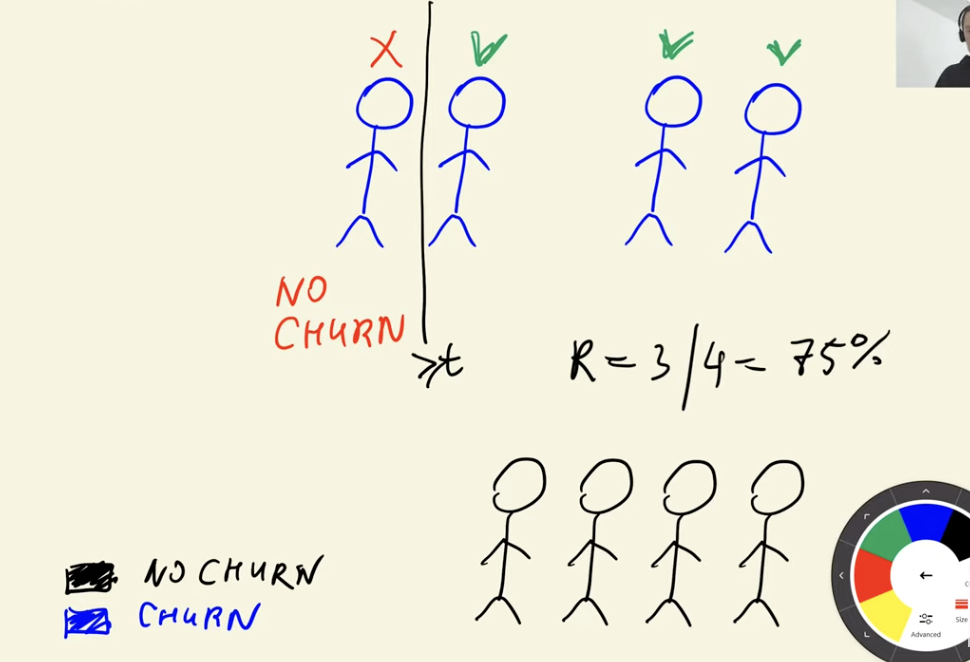

In [ ]:
r = tp / (tp + fn)
r

0.533678756476684

This means that from the people that would churn we could only identify 50% of them.

### 4. ROC Curve

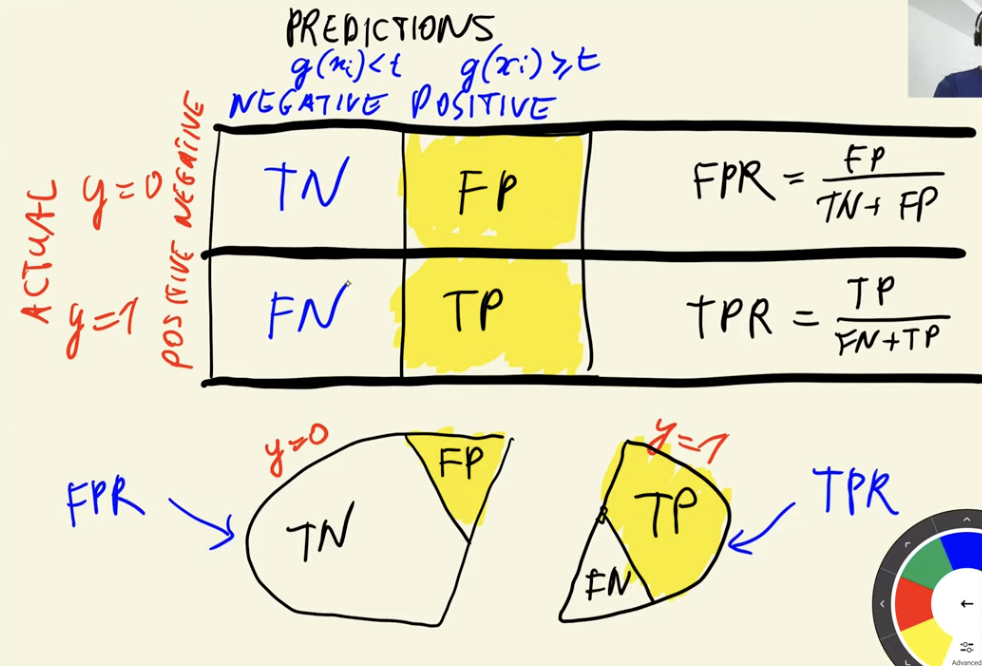

In [ ]:
tpr = tp / (tp + fn)
tpr

0.533678756476684

In [ ]:
fpr = fp / (fp + tn)
fpr

0.093841642228739

<matplotlib.legend.Legend>

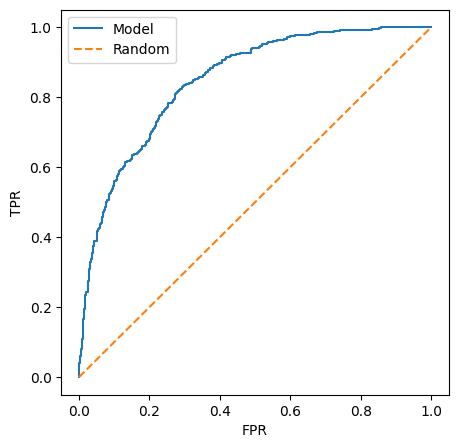

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

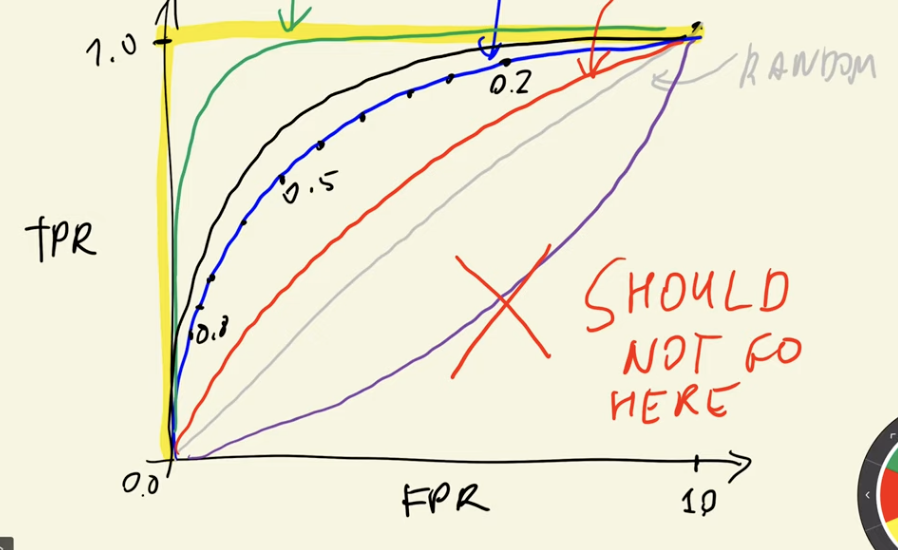

#### 3.1 ROC AUC

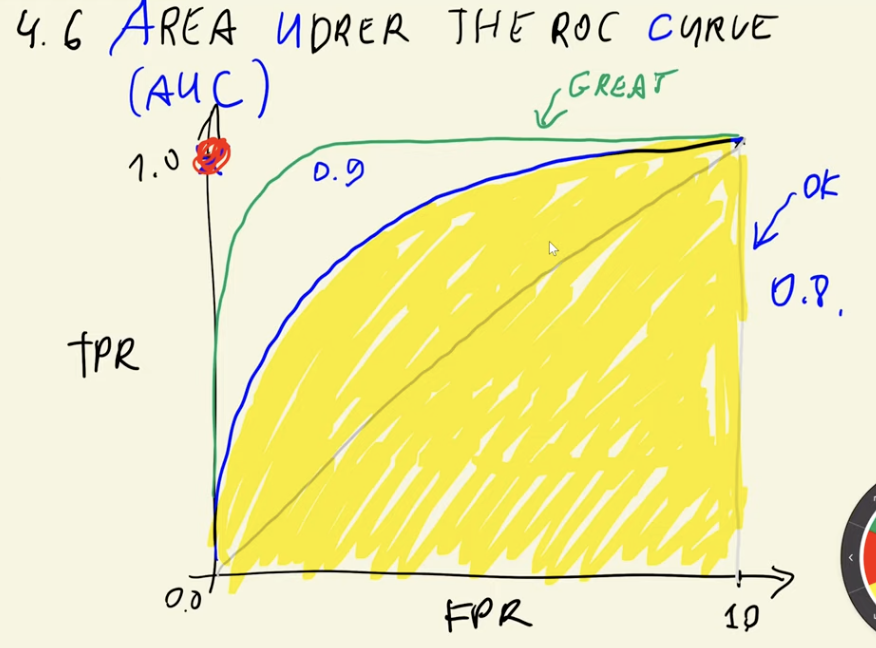

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.8465703331155446

Theory behind auc roc:

In [ ]:
# actual negative and positive examples:
neg = y_pred_val[y_val == 0]
pos = y_pred_val[y_val == 1]

In [ ]:
import random
# Get random samples:
pos_ind = random.randint(0, len(pos)-1)
neg_ind = random.randint(0, len(neg)-1)

In [ ]:
pos[pos_ind] > neg[neg_ind]

True

How many times this happens? Auc ROC!

In [ ]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84832

### 4. K-Fols Validation (parameter tuning)

Once we leave the test set apart, we do the following with the full train dataset:
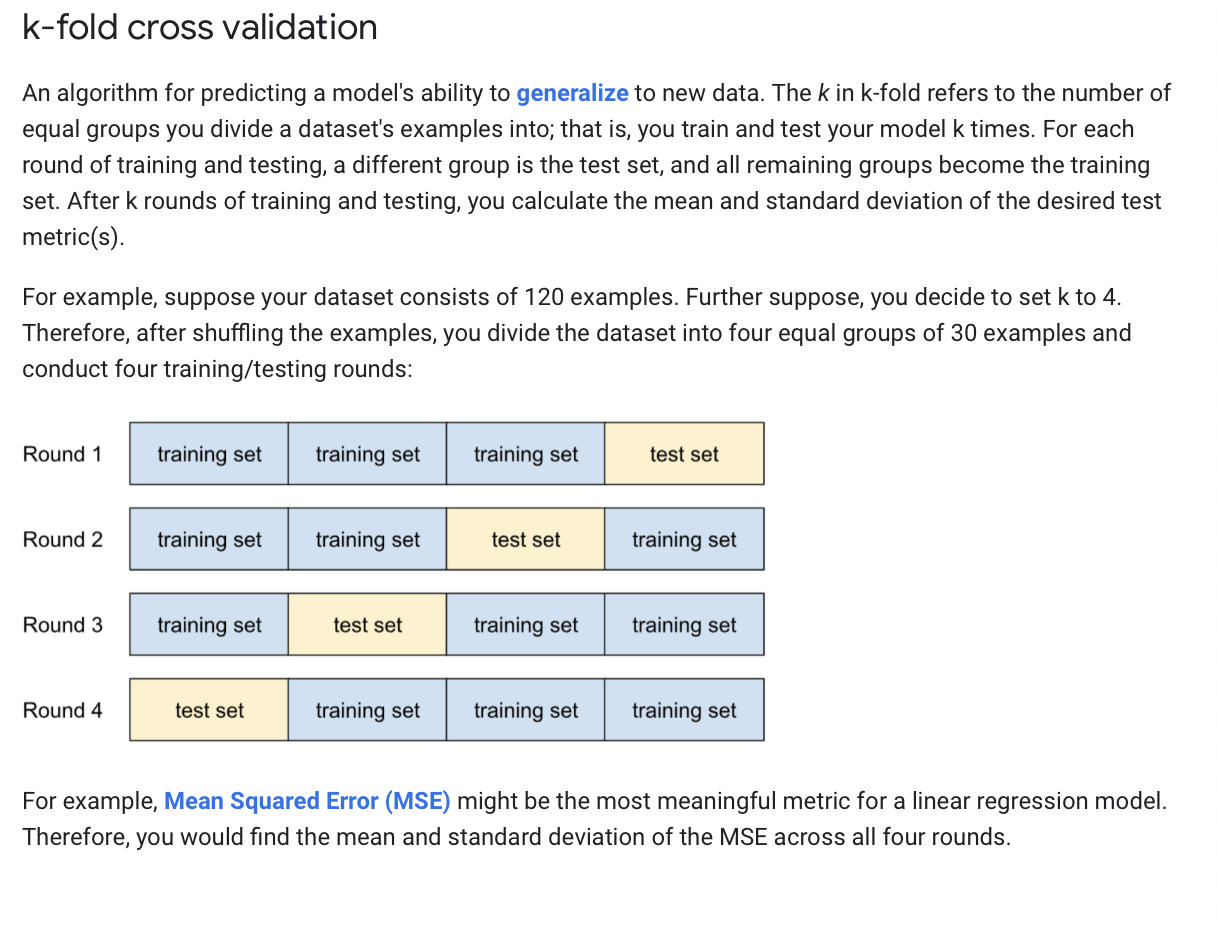
Example:
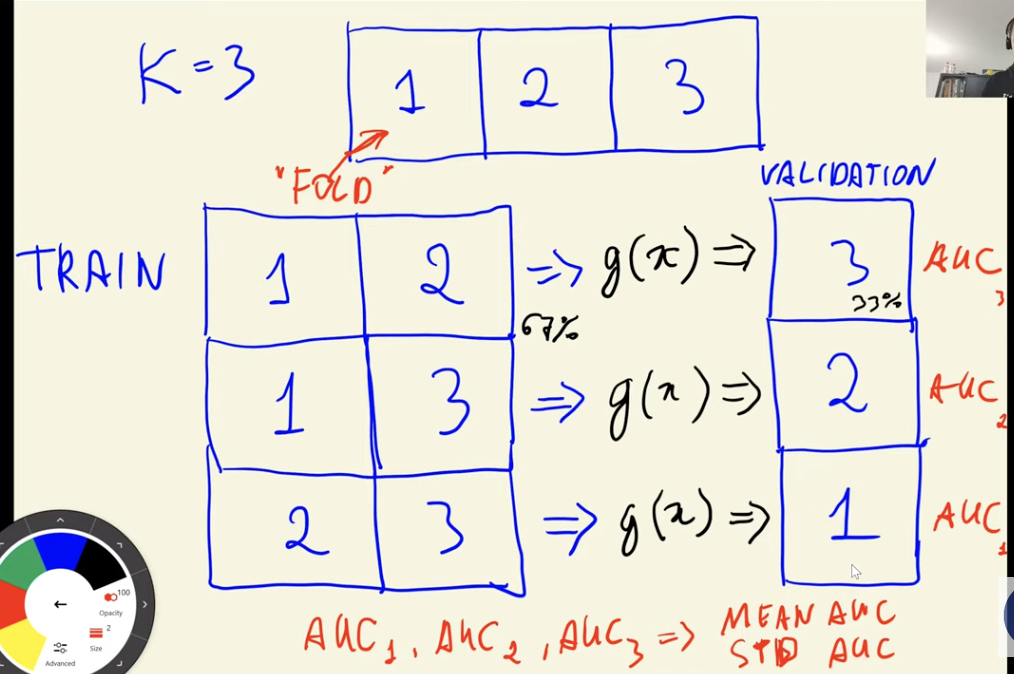

In [ ]:
df_train_full = pd.read_pickle("gs://dz-d-stg-us-ml-zoomcamp/02_churn_prediction/pipeline_root/532579765435/pipeline-log-reg-20231002003225/split-data_445829562513752064/out_df_train_full.pkl")
df_test = pd.read_pickle("gs://dz-d-stg-us-ml-zoomcamp/02_churn_prediction/pipeline_root/532579765435/pipeline-log-reg-20231002003225/split-data_445829562513752064/out_df_test.pkl")

In [ ]:
df_train_full = df_train_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train_full.head()

customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  5442-pptjy    male              0     yes        yes      12          yes   
1  6261-rcvns  female              0      no         no      42          yes   
2  2176-osjuv    male              0     yes         no      71          yes   
3  6161-erdgd    male              0     yes        yes      71          yes   
4  2364-ufrom    male              0      no         no      30          yes   

  multiplelines internetservice       onlinesecurity  ...  \
0            no              no  no internet service  ...   
1            no             dsl                  yes  ...   
2           yes             dsl                  yes  ...   
3           yes             dsl                  yes  ...   
4            no             dsl                  yes  ...   

      deviceprotection          techsupport          streamingtv  \
0  no internet service  no internet service  no internet service   
1                  yes                  yes                   no   
2                   no                  yes                   no   
3                  yes                  yes                  yes   
4                   no                  yes                  yes   

       streamingmovies  contract paperlessbilling              paymentmethod  \
0  no internet service  two year               no               mailed check   
1                  yes  one year               no    credit card (automatic)   
2                   no  two year               no  bank transfer (automatic)   
3                  yes  one year               no           electronic check   
4                   no  one year               no           electronic check   

  monthlycharges  totalcharges  churn  
0          19.70        258.35      0  
1          73.90       3160.55      1  
2          65.15       4681.75      0  
3          85.45       6300.85      0  
4          70.40       2044.75      0  

[5 rows x 21 columns]

In [ ]:
df_train_full.shape, df_test.shape

((5634, 21), (1409, 21))

How does K-fold work?

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
train_idx, val_idx = next(kfold.split(df_train_full))

In [ ]:
train_idx

array([   0,    1,    2, ..., 5631, 5632, 5633])

In [ ]:
len(train_idx), len(val_idx)

(5070, 564)

We take 10% of the training data as validation (10 times).

In [ ]:
df_train = df_train_full.iloc[train_idx]
df_val = df_train_full.iloc[val_idx]

Let's place it all in a function:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def split_preprocess_train_k_folds(
    df_train,
    df_val,
    train_idx: list,
    val_idx: list,
    label: str,
    cat_features: list,
    num_features: list,
    C=1.0, # Hyperparameter
):
    # SPLIT DATASET:
    df_train = df_train.iloc[train_idx].copy()
    df_val = df_val.iloc[val_idx].copy()

    y_train = df_train[label]
    y_val = df_val[label]

    # PREPROCESS:
    ohe = OneHotEncoder(
        drop='first', # Whether to drop one of the features
        sparse=False, # Will return sparse matrix if set True
        handle_unknown='error' # Whether to raise an error 
    ) 
    mct = make_column_transformer(
        (ohe, cat_features),
        remainder='passthrough',
    )
    X_train = mct.fit_transform(df_train[cat_features + num_features])
    X_val = mct.transform(df_val[cat_features + num_features])

    # TRAIN MODEL:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    # PREDICT ON VALIDATION:
    y_pred = model.predict_proba(X_val)[:,1]

    # EVALUATE ON VALIDATION:
    auc = roc_auc_score(y_val, y_pred)

    return auc, model, y_pred, y_val

In [ ]:
numerical = ['tenure', 'monthlycharges']
categorical = [ 'gender',
                'seniorcitizen',
                'partner',
                'dependents',
                'phoneservice',
                'multiplelines',
                'internetservice',
                'onlinesecurity',
                'onlinebackup',
                'deviceprotection',
                'techsupport',
                'streamingtv',
                'streamingmovies',
                'contract',
                'paperlessbilling',
                'paymentmethod',
                ]
label = "churn"

In [ ]:
from tqdm.auto import tqdm

n_splits = 5
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_train_full):
        auc, _, _, _ = split_preprocess_train_k_folds(
            df_train_full,
            df_train_full,
            train_idx,
            val_idx,
            label,
            categorical,
            numerical,
            C, # Hyperparameter
        )
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.818 +- 0.009
C=0.01 0.835 +- 0.009
C=0.1 0.839 +- 0.007
C=0.5 0.840 +- 0.007
C=1 0.840 +- 0.007
C=5 0.840 +- 0.007
C=10 0.840 +- 0.006


Create working model:

In [ ]:
C = 10 # Highest roc auc and smallest standard deviation.

auc, model, y_pred, y_val = split_preprocess_train_k_folds(
    df_train_full,
    df_test,
    df_train_full.index, # Take the whole dataset to train
    df_test.index, # Take the whole dataset to test
    label,
    categorical,
    numerical,
    C, # Hyperparameter
)

In [ ]:
auc

0.8565615283781294